In [80]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import sympy as sp
from IPython.display import clear_output
input_dim = 3



operators_uni = [
    "sin", "cos", "abs", "sqrt", "ln", "exp", "", "square"
]
operators_uni = [
    "sin", "cos", "sqrt", "", "square","zeroise"
]
operators_bin = [ "+", "-", "*", "/"]

#variables = ["const"] + [f"x{i}" for i in range(input_dim)]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [81]:
def combine(x, bin=True):
    if bin:
        return len(operators_bin) * x ** 2 - (len(operators_bin) - 1) * x
    else:
        return len(operators_uni) * x 

In [82]:
def var_gen(n_var):
    return [f"x{i}" for i in range(n_var)]
def uni_gen(n_var):
    var = [i for i in range(n_var)]
    op = []
    for _i in var:
        for _j in operators_uni:
                op.append([_j, _i])
    return op
    
def bin_gen(n_var):
    variables = [i for i in range(n_var)]
    op = []
    for i_ in operators_bin:
        for j_ in variables:
            for k_ in variables:
                if (i_ == "/") and (j_ == k_):
                    pass
                elif (i_ == "-") and (j_ == k_):
                    pass
                elif (i_ == "+") and (j_ == k_):
                    pass
                elif (i_ == "*") and (j_ == k_):
                    pass
                else:
                    op.append([j_, i_, k_])
    op += [[i] for i in variables]
    return op

def bin_(op, x):
    if len(op) == 3:
        a, op, b = op[0], op[1], op[2]
        if op == "/":
            return x[:, a] / (x[:, b] + 0.01)
        elif op == "+":
            return x[:, a] + x[:, b]
        elif op == "*":
            return x[:, a] * x[:, b]
        elif op == "-":
            return x[:, a] - x[:, b]
    else:
        return x[:, op[0]]
def uni_(op, x):
    op, a = op[0], op[1]
    if op == "cos":
        return torch.cos(x[:, a])
    elif op == "sin":
        return torch.sin(x[:, a])
    elif op == "abs":
        return torch.abs(x[:, a])
    elif op == "ln":
        return torch.log(torch.abs(x[:, a]))
    elif op == "sqrt":
        return torch.sqrt(torch.abs(x[:, a]))
    elif op == "exp":
        return torch.exp(x[:, a])
    elif op == "square":
        return torch.square(x[:, a])
    elif op == "":
        return x[:, a]
    elif op=="zeroise":
        return torch.zeros_like(x[:,a])

def select(x, i, proba, current_var,  bin=True):
    if bin:
        operations = bin_gen(current_var)
    else:
        operations = uni_gen(current_var)
    output = torch.Tensor([]).to(device)
    output_var = torch.Tensor([]).to(device)
    for op in operations:
        if bin:
            out = bin_(op, x)
        else:
            out = uni_(op, x)
        output_var = torch.cat((output_var, out.unsqueeze(1)), 1)
    output = torch.Tensor([]).to(device)
    for var_ in range(proba.size()[1]):
        out_ = torch.sum(torch.mul(proba[:, var_, :], output_var), dim=1)
        output = torch.cat((output, out_.unsqueeze(1)), 1)
    return output

def select_argmax(x, proba, current_var,  bin=True):
    proba_argmax = np.zeros_like(proba.cpu().detach().numpy())
    max_indices = np.argmax(proba.cpu().detach().numpy(), axis=2)
    # Setting the corresponding indices to 1
    proba_argmax[np.arange(proba.shape[0])[:, None, None],
               np.arange(proba.shape[1])[None, :, None],
               max_indices[:, :, None]] = 1

    proba_argmax = torch.Tensor(proba_argmax)
    #print("PROB SHAPE", proba.shape)
    #print("Arg SHAPE", proba_argmax.shape)

    if bin:
        operations = bin_gen(current_var)
    else:
        operations = uni_gen(current_var)
    output = torch.Tensor([]).to(device)
    output_var = torch.Tensor([]).to(device)
    for op in operations:
        if bin:
            out = bin_(op, x)
        else:
            out = uni_(op, x)
        output_var = torch.cat((output_var, out.unsqueeze(1)), 1)
    output = torch.Tensor([]).to(device)
    for var_ in range(proba_argmax.size()[1]):
        out_ = torch.sum(proba_argmax[:, var_, :].to(device) * output_var, dim=1)
        output = torch.cat((output, out_.unsqueeze(1)), 1)
    return output

In [83]:
def form(proba, i, model, bin=True, k=0):
    pr_ = torch.mean(proba, dim=0)
    if bin:
        vars = bin_gen(model[i])
    else:
        vars = uni_gen(model[i])
    idx = []
    for c in range(model[i + 1]):
            idx.append(torch.argsort(pr_[c], descending=True)[k])
    formula = [vars[l.detach().cpu()] for l in idx]
    return formula

In [84]:
import torch.nn as nn

class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(x.size(0), *self.shape)

In [85]:
class Formuler(nn.Module):
    def __init__(self, model):
        super(Formuler, self).__init__()
        self.model = model
        self.encoders = nn.ModuleList()

        for i in range(len(model)-1):
                    odd = i % 2 != 0
                    in_dim = model[i]
                    out_dim = combine(model[i], bin=odd) * model[i + 1]
                    encoder = nn.Sequential(
                        nn.Linear(in_dim, out_dim * 4),
                        nn.ReLU(),
                        nn.Linear(out_dim * 4, out_dim),
                        nn.Linear(out_dim, out_dim),
                        nn.Softmax(dim=1)
                    )
                    self.encoders.append(encoder)


    def forward(self, x):
        formula = []
        for i, encoder in enumerate(self.encoders):
            proba = encoder(x)
            proba = proba.view(-1, self.model[i + 1], proba.size()[1] // self.model[i + 1])
            x = select(x, i, proba, self.model[i], bin=(i % 2 != 0))
            f = form(proba, i, self.model, bin=(i % 2 != 0))
            formula.append(f)
        return x, formula
    def forward_test(self, x):
            formula = []
            probas = []
            for i, encoder in enumerate(self.encoders):
                proba = encoder(x)
                proba = proba.view(-1, self.model[i + 1], proba.size()[1] // self.model[i + 1])
                x = select(x, i, proba, self.model[i], bin=(i % 2 != 0))
                f = form(proba, i, self.model, bin=(i % 2 != 0))
                formula.append(f)
                probas.append(proba)
            return x, formula, probas


In [86]:
def decode(formula, x):
    for i in range(len(formula)):
        out = torch.Tensor([]).to(device)
        for f in formula[i]:
            if (i % 2 == 0):
                out_ =  uni_(f, x).unsqueeze(1)
            else:
                out_ =  bin_(f, x).unsqueeze(1)
            out = torch.cat((out, out_), 1)
        x = out
    return x

In [87]:
model = [3, 3, 2, 2, 1]
# Generate random data
x = np.random.rand(10000, model[0])

size_normal = 10000
size_uniform = 10000
size_exponential = 10000

data_normal = np.random.normal(0, 1, size_normal)
data_uniform = np.random.uniform(-5, 5, size_uniform)
data_exponential = np.random.exponential(1, size_exponential)

x = np.array([data_normal, data_uniform, data_exponential]).T

y = x[:, 1] ** 2 + x[:, 0] * np.cos(x[:, 2])
# Convert to PyTorch tensors
labels = torch.tensor(y, dtype=torch.float32)
features = torch.tensor(x, dtype=torch.float32)

# Create a TensorDataset
my_dataset = TensorDataset(features, labels)

# Create a DataLoader
batch_size = 64
my_dataloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=True)
# Instantiate Formuler and set up optimizer
formuler = Formuler(model).to(device)
optimizer = optim.Adam(formuler.parameters(), lr=0.001)
num_epochs = 50
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0001)
criterion = torch.nn.MSELoss()
# Example usage in a training loop
results = []
formulas = set()
for epoch in range(num_epochs):
    losses = []
    w_losses = []
    formula_losses = []
    for batch_features, batch_labels in my_dataloader:
        # Your training code here
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()
        output, formula = formuler(batch_features)
        formula_out = decode(formula, batch_features)
        loss_formula = criterion(formula_out.squeeze(1).requires_grad_(), batch_labels)
        formula = " , ".join([' '.join(str(k) for k in j) for i in formula for j in i])
        loss = criterion(output.squeeze(1).requires_grad_(), batch_labels)
        w_loss = loss + 0 * loss_formula
        #print(loss, not torch.isnan(loss))
        formulas.add(formula)
        losses.append(loss)
        w_losses.append(w_loss)
        w_loss.backward()
        optimizer.step()
        scheduler.step()
        formula_losses.append(loss_formula)

    print(f"EPOCH[{epoch}] loss:{sum(losses) / len(losses):.4f}, weighted_loss:{sum(w_losses) / len(w_losses):.4f}, formula_loss:{sum(formula_losses) / len(formula_losses):.4f}, n_explored_formulas:{len(formulas)}, formula : ({formula})")

EPOCH[0] loss:51.8640, weighted_loss:51.8640, formula_loss:51382360.0000, n_explored_formulas:22, formula : (square 1 , sqrt 2 , sqrt 1 , 1 + 0 , 0 + 2 , square 1 , cos 1 , 0 + 1)
EPOCH[1] loss:2.8454, weighted_loss:2.8454, formula_loss:10429.7773, n_explored_formulas:24, formula : (square 1 , sqrt 2 , sqrt 1 , 1 + 0 , 0 + 2 ,  1 , cos 1 , 0 + 1)
EPOCH[2] loss:1.9442, weighted_loss:1.9442, formula_loss:3.6084, n_explored_formulas:25, formula : (square 1 ,  1 , sqrt 1 , 0 / 2 , 0 + 2 ,  1 , cos 1 , 0 + 1)
EPOCH[3] loss:0.9254, weighted_loss:0.9254, formula_loss:3.6074, n_explored_formulas:25, formula : (square 1 ,  1 , sqrt 1 , 0 / 2 , 0 + 2 ,  1 , cos 1 , 0 + 1)
EPOCH[4] loss:61.7955, weighted_loss:61.7955, formula_loss:3.6725, n_explored_formulas:32, formula : (square 1 ,  1 , square 0 , 0 / 1 , 0 ,  1 , cos 1 , 0 + 1)
EPOCH[5] loss:10.5237, weighted_loss:10.5237, formula_loss:4.0274, n_explored_formulas:32, formula : (square 1 ,  1 , sqrt 1 , 0 / 1 , 0 + 2 ,  1 , cos 1 , 0 + 1)
EPOCH

KeyboardInterrupt: 

tensor(0.0927)
torch.Size([10000, 3])


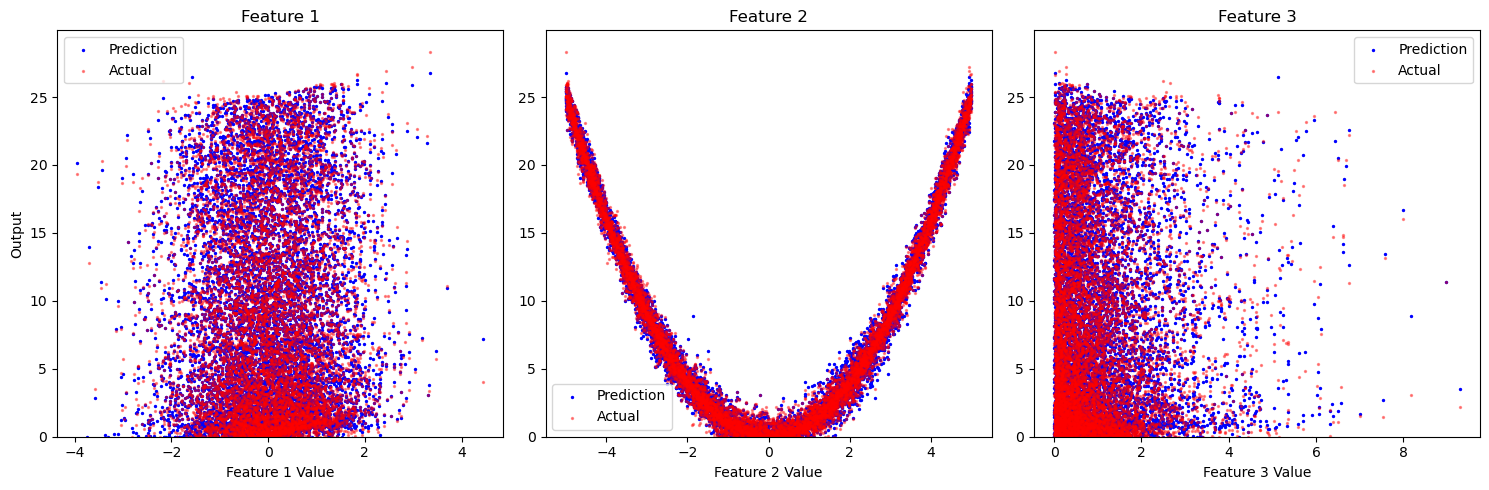

In [ ]:
import matplotlib.pyplot as plt

x, formula= formuler(features.to(device))

x = x.detach().cpu()
print(criterion(x.squeeze(1), labels))
print(features.shape)

# Creating a figure with 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
size = 2
alpha = 0.4
# Assuming features has at least 3 columns
# Adjust the indices as needed to plot different features

# Scatter plot for feature 1
axes[0].scatter(features[:, 0], x, color="blue", label='Prediction', s=size)
axes[0].scatter(features[:, 0], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[0].set_title('Feature 1')
axes[0].set_xlabel('Feature 1 Value')
axes[0].set_ylabel('Output')
axes[0].set_ylim(0)
axes[0].legend()

# Scatter plot for feature 2
axes[1].scatter(features[:, 1], x, color="blue", label='Prediction', s=size)
axes[1].scatter(features[:, 1], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[1].set_title('Feature 2')
axes[1].set_xlabel('Feature 2 Value')
axes[1].set_ylim(0)
axes[1].legend()

# Scatter plot for feature 3
axes[2].scatter(features[:, 2], x, color="blue", label='Prediction', s=size)
axes[2].scatter(features[:, 2], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[2].set_title('Feature 3')
axes[2].set_xlabel('Feature 3 Value')
axes[2].set_ylim(0)
axes[2].legend()


# Adjust the layout
plt.tight_layout()
plt.show()


### Search space

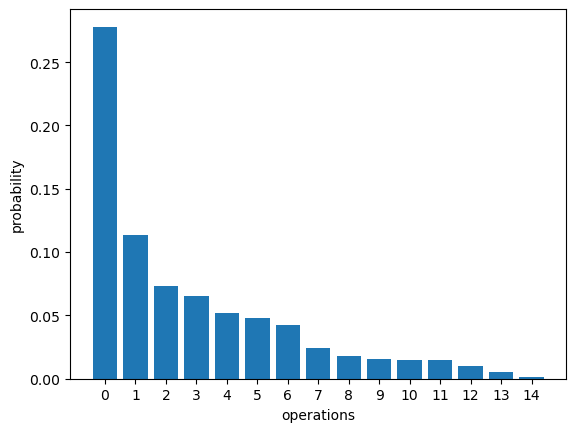

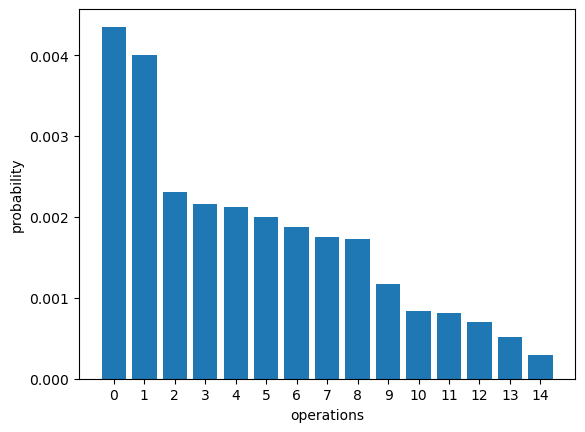

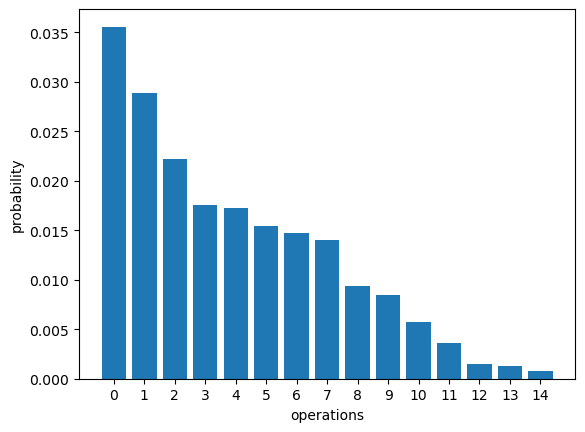

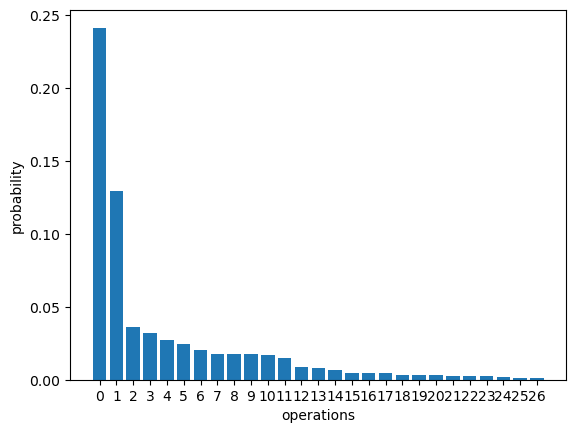

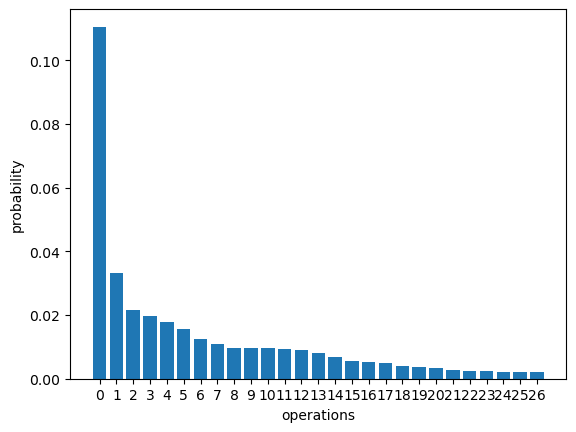

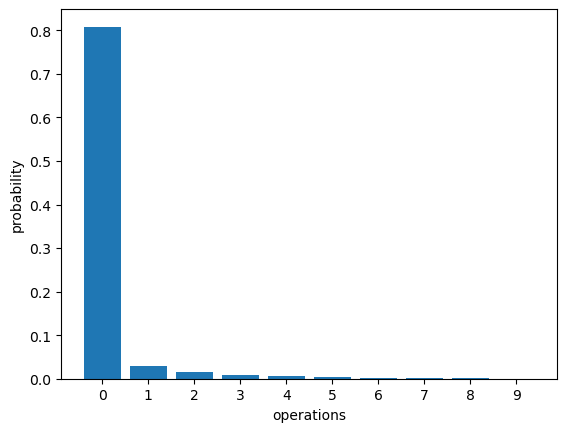

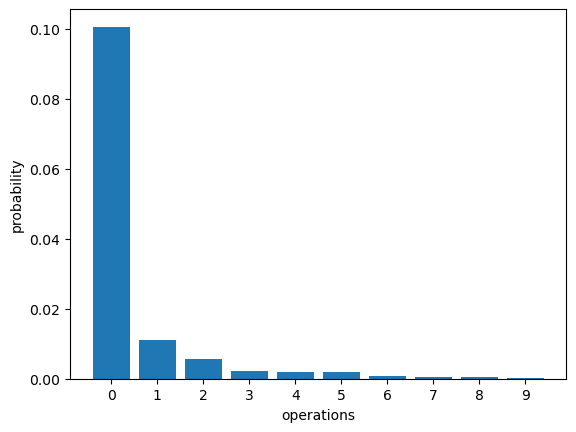

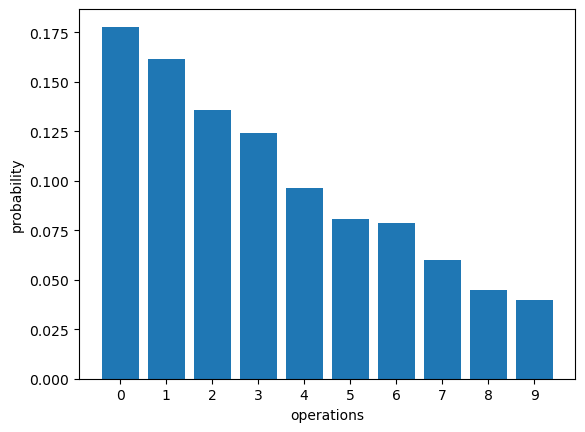

In [ ]:
_, formula, probas = formuler.forward_test(features.to(device))
for m in range(len(probas)):
    proba = probas[m]
    bin = (m % 2 != 0)
    proba = torch.mean(proba, dim=0).detach().cpu()
    for i in range(proba.size()[0]):
        t = [str(k) for k in range(proba[i].size()[0])]
        x, _ = torch.sort(proba[i], dim=0, descending=True)
        plt.figure()
        plt.bar(t, x)
        plt.ylabel("probability")
        plt.xlabel("operations")
        plt.savefig(f"plot/plot{m}-{i}.pdf")

In [ ]:
def split_vector(vector, shape):
    result = []
    start_index = 0
    for size in shape:
        end_index = start_index + size
        result.append(vector[start_index:end_index])
        start_index = end_index
    return result


In [ ]:
_, formula, probas = formuler.forward_test(features.to(device))
prob_size = 1
formula_space = []
for m in range(len(probas)):
    proba = probas[m]
    space = [form(proba, m, model, bin=(m % 2 != 0), k=k) for k in range(prob_size)]
    s = []    
    for i in range(len(space[0])):
        op_ = [s_[i] for s_ in space]
        op_ = list(set(tuple(inner_list) for inner_list in  op_))
        op_ = [list(inner_tuple) for inner_tuple in op_]
        s.append(op_)
    formula_space.append(s)
formula_space

[[[['square', 1]], [['square', 2]], [['square', 1]]],
 [[[2, '/', 1]], [[2, '/', 1]]],
 [[['sqrt', 0]], [['', 0]]],
 [[[0, '-', 1]]]]

In [ ]:
import itertools
from tqdm import tqdm

# Generate and print all possible n-base vectors of size k
losses = []
for_ = []

# Define the tqdm wrapper
for vector in tqdm(itertools.product(range(prob_size), repeat=sum(model[1:])), desc="Processing Vectors", unit="vector"):
    _f = [
        [
            formula_space[i][j][split_vector(vector, model[1:])[i][j]]
            for j in range(len(split_vector(vector, model[1:])[i]))
        ]
        for i in range(len(formula_space))
    ]
    out = decode(_f, features.to(device))
    loss_f = criterion(out.squeeze(1), labels.to(device)).detach().cpu()
    losses.append(float(loss_f))
    for_.append(_f)


Processing Vectors: 1vector [00:00, 499.02vector/s]


In [ ]:
print(min(losses))
min_for = for_[losses.index(min(losses))]
min_for

94844.5703125


[[['square', 1], ['square', 2], ['square', 1]],
 [[2, '/', 1], [2, '/', 1]],
 [['sqrt', 0], ['', 0]],
 [[0, '-', 1]]]

tensor(94844.5703)
torch.Size([10000, 3])


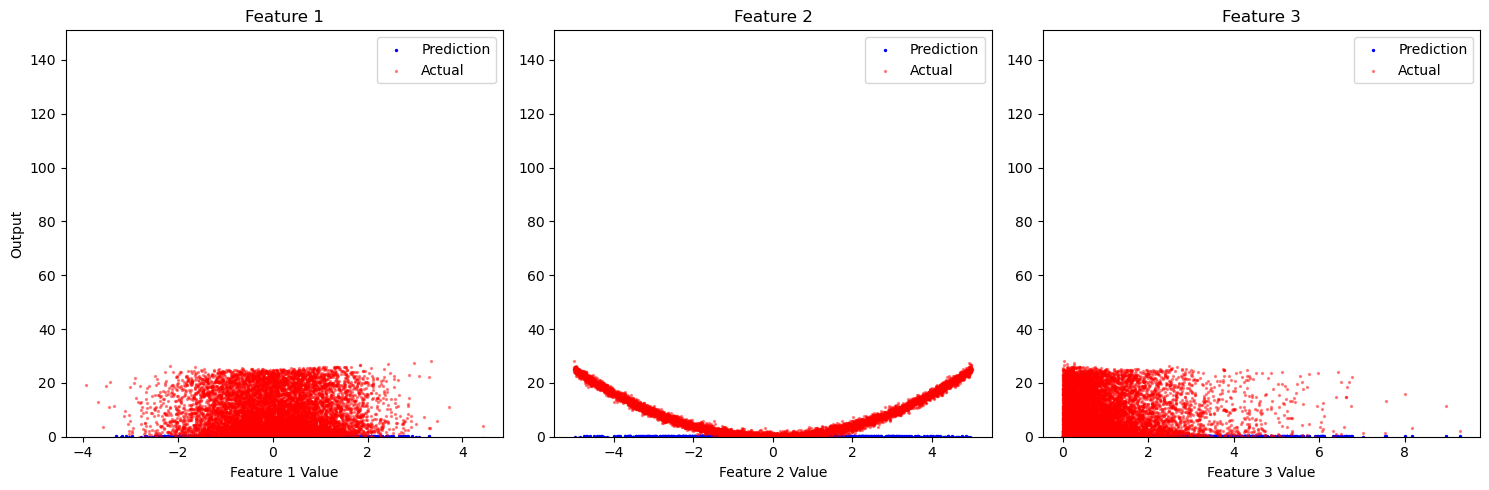

In [ ]:
import matplotlib.pyplot as plt

x = decode(min_for, features.to(device))
print(criterion(x.squeeze(1).requires_grad_(), labels.to(device)).detach().cpu())
x = x.detach().cpu()
print(features.shape)

# Creating a figure with 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
size = 2
alpha = 0.4
# Assuming features has at least 3 columns
# Adjust the indices as needed to plot different features

# Scatter plot for feature 1
axes[0].scatter(features[:, 0], x, color="blue", label='Prediction', s=size)
axes[0].scatter(features[:, 0], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[0].set_title('Feature 1')
axes[0].set_xlabel('Feature 1 Value')
axes[0].set_ylabel('Output')
axes[0].set_ylim(0)
axes[0].legend()

# Scatter plot for feature 2
axes[1].scatter(features[:, 1], x, color="blue", label='Prediction', s=size)
axes[1].scatter(features[:, 1], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[1].set_title('Feature 2')
axes[1].set_xlabel('Feature 2 Value')
axes[1].set_ylim(0)
axes[1].legend()

# Scatter plot for feature 3
axes[2].scatter(features[:, 2], x, color="blue", label='Prediction', s=size)
axes[2].scatter(features[:, 2], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[2].set_title('Feature 3')
axes[2].set_xlabel('Feature 3 Value')
axes[2].set_ylim(0)
axes[2].legend()


# Adjust the layout
plt.tight_layout()
plt.show()


In [ ]:
#torch.save(model, 'model.pth')

### Proba results


In [ ]:
def change(data, dimension=1, op=1):
    if op==0:
        return data
    else:
        # Calculate softmax along the specified dimension
        exp_data = np.exp(data - np.max(data, axis=dimension, keepdims=True))
        softmax_data = exp_data / np.sum(exp_data, axis=dimension, keepdims=True)
        return softmax_data

In [ ]:
_, formula, probas = formuler.forward_test(features.to(device))
prob_size = 5
formula_space = []
proba_max = []
for m in range(len(probas)):
    proba = probas[m]
    space = [form(proba, m, model, bin=(m % 2 != 0), k=k) for k in range(prob_size)]
    proba_max_ = torch.mean(torch.sort(proba, descending=True)[0][:, :, :prob_size], dim=0).tolist()
    s = []    
    for i in range(len(space[0])):
        op_ = [s_[i] for s_ in space]
        op_ = list(set(tuple(inner_list) for inner_list in  op_))
        op_ = [list(inner_tuple) for inner_tuple in op_]
        s.append(op_)
    proba_max.append(proba_max_)
    formula_space.append(s)
proba_max = [np.array(proba_max[i]) for i in range(len(proba_max))]
proba_max = [change(proba_max[i]) for i in range(len(proba_max))] 
print(proba_max)
def decode_space(formula_space, proba_max, x):
    for i in range(len(formula_space)):
        out = torch.Tensor([])
        for j in range(len(formula_space[i])):
            for k in range(len(formula_space[i][j])):
                if k == 0:
                    if (i % 2 == 0):
                        out_ =  proba_max[i][j][k] * uni_(formula_space[i][j][k], x).unsqueeze(1)
                    else:
                        out_ =  proba_max[i][j][k] * bin_(formula_space[i][j][k], x).unsqueeze(1)
                else:
                    if (i % 2 == 0):
                        out_ +=  proba_max[i][j][k] * uni_(formula_space[i][j][k], x).unsqueeze(1)
                    else:
                        out_ +=  proba_max[i][j][k] * bin_(formula_space[i][j][k], x).unsqueeze(1)
            out = torch.cat((out, out_), 1)
        x = out
    return x
decoded_features = decode_space(formula_space, proba_max, features)
criterion(decoded_features.to(device).squeeze(1), labels.to(device)).detach().cpu()


[array([[0.23563192, 0.19991733, 0.19087008, 0.18776978, 0.1858109 ],
       [0.20032815, 0.20014231, 0.1999022 , 0.19983369, 0.19979365],
       [0.20296225, 0.20043651, 0.19933804, 0.19889222, 0.19837097]]), array([[0.24757565, 0.19132414, 0.18882716, 0.18668162, 0.18559142],
       [0.21648232, 0.19755036, 0.19640212, 0.19510256, 0.19446264]]), array([[0.3560282 , 0.16337443, 0.16111464, 0.15992373, 0.15955899],
       [0.2163412 , 0.19677544, 0.19595929, 0.19552889, 0.19539517]]), array([[0.21407893, 0.20351866, 0.19690068, 0.19446546, 0.19103627]])]


tensor(1.5218e+19)

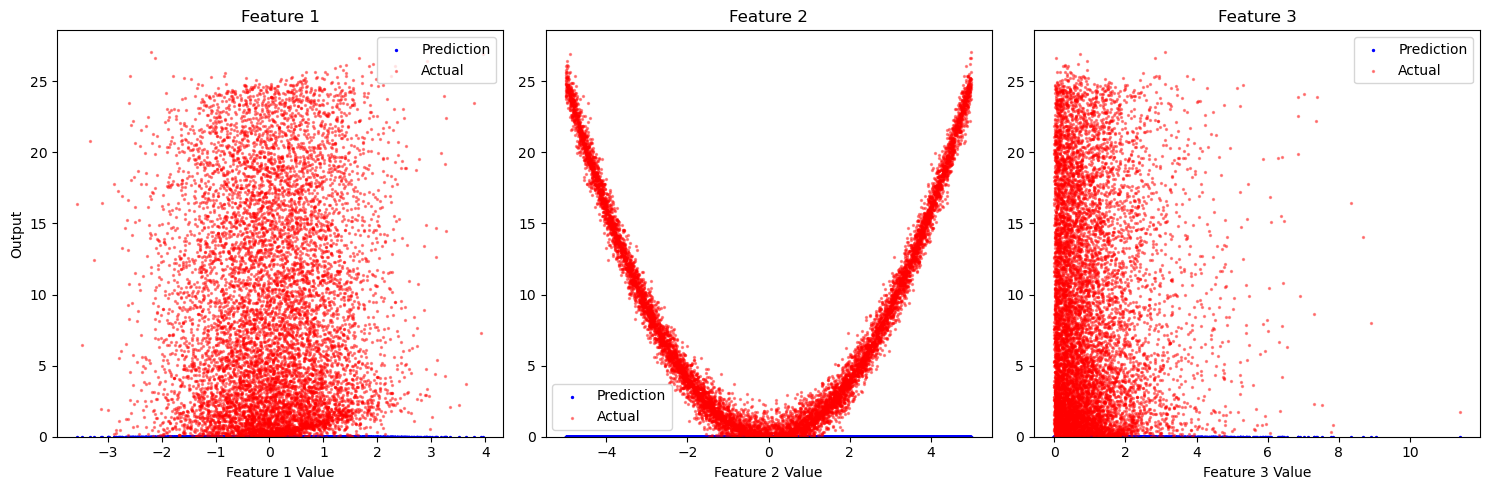

In [ ]:
import matplotlib.pyplot as plt

x = decoded_features.detach().numpy()
features = features.detach()
# Creating a figure with 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
size = 2
alpha = 0.4
# Assuming features has at least 3 columns
# Adjust the indices as needed to plot different features

# Scatter plot for feature 1
axes[0].scatter(features[:, 0], x, color="blue", label='Prediction', s=size)
axes[0].scatter(features[:, 0], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[0].set_title('Feature 1')
axes[0].set_xlabel('Feature 1 Value')
axes[0].set_ylabel('Output')
axes[0].set_ylim(0)
axes[0].legend()

# Scatter plot for feature 2
axes[1].scatter(features[:, 1], x, color="blue", label='Prediction', s=size)
axes[1].scatter(features[:, 1], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[1].set_title('Feature 2')
axes[1].set_xlabel('Feature 2 Value')
axes[1].set_ylim(0)
axes[1].legend()

# Scatter plot for feature 3
axes[2].scatter(features[:, 2], x, color="blue", label='Prediction', s=size)
axes[2].scatter(features[:, 2], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[2].set_title('Feature 3')
axes[2].set_xlabel('Feature 3 Value')
axes[2].set_ylim(0)
axes[2].legend()


# Adjust the layout
plt.tight_layout()
plt.show()
